In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.utils import pickle_open
from cohlib.plot import draw_raster_single
from cohlib.sample import sample_spikes_from_xs

from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence
from cohlib.utils import (
    transform_cov_r2c,
    transform_cov_c2r,
    rearrange_mat,
    reverse_rearrange_mat,
)

def quick_conv_c2r(ccov, K):
    return reverse_rearrange_mat(transform_cov_c2r(ccov), K)
def quick_conv_r2c(rcov, K):
    return transform_cov_r2c(rearrange_mat(rcov, K))

In [2]:
def Gamma_est_from_zs(zs, dc=False):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams[lams < 0] = 0
    return lams

In [3]:
link = 'relu'
init_type = 'flat'
optim_type = 'BFGS'
alpha = 400.0
delta = 1e-3
sample_length=1000
fs = 1000
J_scaling = sample_length/2

em_iters = 20
seed = 7
L=50
C=1
K=2

alpha = 400
alpha=float(alpha)
alphas = np.array([alpha, alpha])



model_path = f'saved/fitted_models/singlefreq_10_delta{link}_poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted.pkl'
# seed_mod = 5
# model_path = f'saved/fitted_models/singlefreq_10_delta{link}_poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed_mod}_{init_type}_{optim_type}_fitted.pkl'
data_path = f'saved/synthetic_data/singlefreq_10_latent_delta{link}_{K}_{L}_{sample_length}_{seed}.pkl'

# model_path = f'saved/fitted_models/simple_delta{link}_poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted.pkl'
# data_path = f'saved/synthetic_data/simple_latent_delta{link}_{K}_{L}_{sample_length}_{seed}.pkl'
# data_path = f'saved/synthetic_data/singlefreq_10_delta{link}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}.pkl'


model_load = pickle_open(model_path)
data_load = pickle_open(data_path)

In [4]:
model_load.keys()

dict_keys(['Gamma', 'latent_true', 'spikes', 'lams', 'tapers', 'Wv', 'track', 'inv_init'])

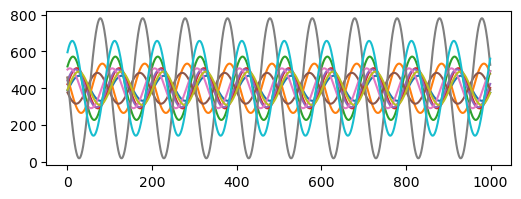

In [5]:
l = 25
k = 0
xs = data_load['latent']['xs']
lams = alpha + xs
fig, ax = plt.subplots(1,figsize=(6,2))
for l in range(10):
    ax.plot(lams[l,k,:])

In [7]:
r = 5
model_load['track'][0][r]['inv']

array([[ 1.21947601e-03,  5.99633882e-29,  8.63183570e-07,
         1.10511151e-09],
       [-5.99633882e-29,  1.21947601e-03, -1.10511151e-09,
         8.63183570e-07],
       [ 8.63183570e-07, -1.10511151e-09,  1.21951527e-03,
         9.49449636e-29],
       [ 1.10511151e-09,  8.63183570e-07, -9.49449636e-29,
         1.21951527e-03]])

In [8]:
J = 1
r = 18

In [67]:
from cohlib.alg.em_sgc import get_trial_obj
l = 0

def real_optim(model_load, r, l):
    W = model_load['Wv']
    gamma_real_inv_r = model_load['track'][0][r]['inv']
    spikes = model_load['spikes']
    spikes_grouped = [spikes[:,:,k,:] for k in range(K)]
    data = spikes_grouped
    Gamma_prev_inv = gamma_real_inv_r
    params = [dict(alpha=alpha) for k in range(K)]
    taper = None
    obs_model = 'poisson-relu-delta'
    optim_type = 'BFGS'


    trial = get_trial_obj(data, l, W, Gamma_prev_inv, params, taper=taper, obs_model=obs_model, optim_type=optim_type, Gamma_prev_logdet=None)
    mus, Ups_inv = trial.laplace_approx(100)
    return mus, Ups_inv

In [142]:
from functools import partial
import jax.numpy as jnp
# one trial, across neurons
# need to make data, W, Gamma_prev_inv jnp and complex
def get_cost_func(trial_data, alpha, W, Gamma_prev_inv, fs=1e3):
    K = len(trial_data)
    J = W.shape[1]
    C = 1
    delta = 1/fs

    def obs_cost_k(data_k, z_k):
        x = (W @ z_k).real
        lamb = alpha + x

        lamb = jnp.where(lamb <=0, jnp.nan, lamb)

        # lamb = lamb.at[lamb_filt].set(jnp.nan)
        
        log_lamb = jnp.nan_to_num(jnp.log(lamb), nan=0, neginf=0, posinf=0)
        obs_cost_pre = data_k * (jnp.log(delta) + log_lamb) - jnp.nan_to_num(lamb)*delta
        obs_cost = C*obs_cost_pre.sum()

        return obs_cost

    def cost_func(z):
        obs_terms = jnp.array([obs_cost_k(trial_data[k], z[k*J:k*J+J]) for k in range(K)]).sum()
        prior_term = z.conj().T @ Gamma_prev_inv @ z

        cost = obs_terms - prior_term

        return -cost[0]
    return cost_func




In [69]:
from cohlib.conv import conv_v_to_z
import jax.scipy.optimize as jop
from jax import grad, hessian
def complex_optim(model_load, r, l, max_iter):
    Wv = model_load['Wv']
    spikes = model_load['spikes']
    spikes_grouped = [spikes[:,:,k,:] for k in range(K)]
    data = spikes_grouped
    evens = np.arange(Wv.shape[1]) % 2 == 0
    W = Wv[:,evens] - 1j*Wv[:,~evens]
    jnp_trial_data = [jnp.array(group_data[l,:,:]) for group_data in data]
    jnp_W = jnp.array(W)

    gamma_complex_r = model_load['track'][0][r]['gamma']
    gamma_complex_r_inv = np.stack([np.linalg.inv(gamma_complex_r[j,:,:]) for j in range(J)])

    jnp_Gamma_prev_inv = jnp.array(gamma_complex_r_inv)
    jax_cost_func = get_cost_func(jnp_trial_data, alpha, jnp_W, jnp_Gamma_prev_inv)
    cost_grad = grad(jax_cost_func, holomorphic=True)
    cost_hess = hessian(jax_cost_func, holomorphic=True)
    # cost_grad = grad(jax_cost_func)
    # cost_hess = hessian(jax_cost_func)
    z_init = jnp.zeros(J*K, dtype=complex)

    z_est = z_init
    for _ in range(max_iter):
        z_est = z_est - (jnp.linalg.inv(cost_hess(z_est)) @ cost_grad(z_est)).conj()
        # z_est = z_est - cost_grad(z_est)/cost_hess(z_est)
    # Result = jop.minimize(fun=jax_cost_func, x0=z_init, method='BFGS', options={'maxiter':50000})
    z_hess = cost_hess(z_est)

    return z_est, z_hess

In [203]:
r = 15
mus_real = []
mus_real_complex = []
Ups_invs_real = []

mus_complex = []
Ups_invs_complex = []

for l in range(10):
    print(l)
    real_est_real, real_hess = real_optim(model_load, r, l)
    mus_real.append(real_est_real)
    Ups_invs_real.append(real_hess)
    real_est = conv_v_to_z(real_est_real, axis=0)
    complex_est, complex_hess = complex_optim(model_load, r, l, 10)
    mus_complex.append(complex_est)
    Ups_invs_complex.append(complex_hess)


complex_true = jnp.array(data_load['latent']['zs'][l,:,0])

0
1
2
3
4
5
6
7
8
9


In [204]:
print(complex_true)
print(real_est)
print(complex_est)

[ 14743.691-14302.096j -11577.625 +9147.906j]
[15584.80668838-15579.16237053j -8767.79211587 +2527.18634697j]
[14929.787-14237.136j  -9201.689 +3544.8755j]


In [191]:
from jax.scipy.linalg import block_diag
Wv = model_load['Wv']
evens = np.arange(Wv.shape[1]) % 2 == 0
W = Wv[:,evens] - 1j*Wv[:,~evens]
jnp_W = jnp.array(W)
# cost_grad = grad(jax_cost_func, holomorphic=True)
# cost_hess = hessian(jax_cost_func, holomorphic=True)
alpha = 400

def e_step(data, gamma_prev_inv):
    max_iter = 10
    L = data[0].shape[0]
    K = gamma_prev_inv.shape[1]

    mus = jnp.zeros((L,K), dtype=complex)
    Ups_invs = jnp.zeros((L,K), dtype=complex)

    for l in range(L):
        if l % 5 == 0:
            print(l)
        jnp_trial_data = [jnp.array(group_data[l,:,:]) for group_data in data]
        jax_cost_func = get_cost_func(jnp_trial_data, alpha, jnp_W, gamma_prev_inv)
        cost_grad = grad(jax_cost_func, holomorphic=True)
        cost_hess = hessian(jax_cost_func, holomorphic=True)
        z_init = jnp.zeros(J*K, dtype=complex)

        z_est = z_init
        for _ in range(max_iter):
            z_est = z_est - (jnp.linalg.inv(cost_hess(z_est)) @ cost_grad(z_est)).conj()

        mus = mus.at[l,:].set(z_est) 
        Ups_invs = Ups_invs.at[l,:].set(jnp.diag(cost_hess(z_est)))


    return mus, Ups_invs




    # return new sigma estimate
    # for l in L:
    # get mu / Upsilon 
    # compute sigmas
    pass

def m_step(mus, Ups_invs):
    L = mus.shape[0]
    K = mus.shape[1]
    sigmas = jnp.zeros((L,J,K,K), dtype=complex)
    for l in range(L):
        sigma_l = jnp.outer(mus[l,:], mus[l,:].conj()) + jnp.diag(1/(Ups_invs[l,:]))
        sigmas = sigmas.at[l,0,:,:].set(sigma_l)
    return sigmas.mean(0)


In [192]:
spikes = model_load['spikes']
spikes_mod = spikes[:10,:,:,:]
spikes_grouped = [spikes_mod[:,:,k,:] for k in range(K)]

In [196]:
gamma_inv_init = jnp.zeros((J,K,K), dtype=complex) + jnp.eye(K)[None,:]*1e-1

gamma_prev_inv = gamma_inv_init
track = []
for r in range(5):
    mus, Ups_invs = e_step(spikes_grouped, gamma_prev_inv)
    gamma_update = m_step(mus, Ups_invs)

    gamma_prev_inv = jnp.linalg.inv(gamma_update)
    track.append(gamma_update)


0
5
0
5
0
5
0
5
0
5


In [198]:
track[0]

Array([[[ 2.5001848e+00-1.731235e-08j, -1.5740065e-04+2.672449e-05j],
        [-1.5740065e-04-2.672449e-05j,  2.5001571e+00-3.417510e-08j]]],      dtype=complex64)

In [206]:
[x.squeeze() for x in track]

[Array([[ 2.5001848e+00-1.731235e-08j, -1.5740065e-04+2.672449e-05j],
        [-1.5740065e-04-2.672449e-05j,  2.5001571e+00-3.417510e-08j]],      dtype=complex64),
 Array([[ 6.250578e-01-1.0822152e-09j, -9.840266e-06+1.6707439e-06j],
        [-9.840266e-06-1.6707439e-06j,  6.250491e-01-2.1361988e-09j]],      dtype=complex64),
 Array([[ 1.5626517e-01-6.7647367e-11j, -6.1497400e-07+1.0441421e-07j],
        [-6.1497400e-07-1.0441421e-07j,  1.5626289e-01-1.3351471e-10j]],      dtype=complex64),
 Array([[ 3.9066341e-02-4.2279179e-12j, -3.8435200e-08+6.5257746e-09j],
        [-3.8435200e-08-6.5257746e-09j,  3.9065763e-02-8.3449280e-12j]],      dtype=complex64),
 Array([[ 9.7665889e-03-2.6423563e-13j, -2.4021902e-09+4.0785916e-10j],
        [-2.4021902e-09-4.0785916e-10j,  9.7664436e-03-5.2154488e-13j]],      dtype=complex64)]

In [165]:
1/Ups_invs

Array([[499.95154-0.00209023j, 499.95203-0.00079273j],
       [499.94736-0.00202381j, 499.94904-0.00062065j],
       [499.95145+0.00019162j, 499.9523 -0.00075792j],
       [499.9501 +0.00114148j, 499.9453 -0.0021846j ],
       [499.954  -0.00193193j, 499.9508 +0.00068591j],
       [499.9558 +0.00189751j, 499.9551 -0.00328284j],
       [499.95358-0.00069349j, 499.9503 +0.00107847j],
       [499.9526 +0.00077763j, 499.9476 +0.00067782j],
       [499.9478 -0.00340515j, 499.95062-0.00070398j],
       [499.9534 +0.00267479j, 499.95312-0.00093342j]], dtype=complex64)

In [157]:
mus_outer = jnp.einsum('lk,lj->lkj', mus, mus.conj())
Upss = jnp.stack([jnp.diag(1/Ups_invs[l]) for l in range(10)])

In [158]:
(mus_outer + Upss).mean(0)

Array([[501.82504  -0.00034618j,  -1.5737075+0.2671939j ],
       [ -1.5737075-0.2671939j , 501.5466   -0.00068339j]],      dtype=complex64)

In [156]:
mus

Array([[-0.43208656-0.4402004j ,  0.0033116 +0.28306773j],
       [ 0.7546627 +0.7121716j , -0.15950048-1.148464j  ],
       [ 0.8110579 -0.82244134j, -0.99284124+0.697708j  ],
       [ 0.00242937-0.90346813j, -0.08370975+1.5786978j ],
       [ 0.28101844-0.9391515j ,  0.12481097+0.72024536j],
       [-0.37517   +0.4881068j ,  0.39029354-0.13475668j],
       [ 0.8360345 -0.6360537j , -0.75845146+0.58219796j],
       [ 1.0893896 +2.6719162j , -0.799244  -2.670461j  ],
       [-0.23917104-0.87375337j, -0.0449371 +0.6921864j ],
       [ 1.390169  -1.2660018j , -0.7980218 +0.2368555j ]],      dtype=complex64)

In [160]:
track[0].mean(0)

Array([[[501.82504-0.00034618j, 498.37692+0.26651052j],
        [498.37802-0.26754007j, 501.5466 -0.00068339j]]], dtype=complex64)

In [131]:
gamma_inv_init

Array([[[0.001+0.j, 0.   +0.j],
        [0.   +0.j, 0.001+0.j]]], dtype=complex64)

In [129]:
data_load['latent']['Gamma']

array([[[ 2.00000000e+08      +0.j       ,
         -1.83910222e+08-5747194.4375007j],
        [-1.83910222e+08+5747194.4375007j,
          2.00000000e+08      +0.j       ]]])

In [125]:
gamma_update

Array([[[501.82504-0.00034618j, 498.37692+0.26651052j],
        [498.37802-0.26754007j, 501.5466 -0.00068339j]]], dtype=complex64)

In [117]:
track

[Array([[[0.005-3.4627778e-14j, 0.005+2.6656191e-11j],
         [0.005-2.6759164e-11j, 0.005-6.8348816e-14j]]], dtype=complex64),
 Array([[[4.72243e-10+3.1827370e-20j, 4.72243e-10+1.2646213e-18j],
         [4.72243e-10-1.3043826e-18j, 4.72243e-10+1.5147735e-20j]]],      dtype=complex64)]

In [98]:
x = [track[r][0,0,0].real for r in range(5)]

In [99]:
x

[Array(0.005, dtype=float32),
 Array(4.72243e-10, dtype=float32),
 Array(-1.2278701e-09, dtype=float32),
 Array(nan, dtype=float32),
 Array(nan, dtype=float32)]

In [328]:
gamma_update.real

Array([[[3.1249999e-04, 8.4469037e-13],
        [8.4469037e-13, 3.1249999e-04]]], dtype=float32)